In [88]:
# !pip install datasets==1.6.2
# !pip install pororo
# !pip install python-mecab-ko
# !pip install seaborn
# !pip install matplotlib
# !pip install gensim

In [1]:
import json
import zipfile
from datasets import load_from_disk
from collections import OrderedDict
from tqdm import tqdm
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from pororo import Pororo
from konlpy.tag import Mecab

In [2]:
train_dataset = load_from_disk('/opt/ml/code/data/train_dataset/train')
print(train_dataset)

Dataset({
    features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 3952
})


In [3]:
valid_dataset = load_from_disk('/opt/ml/code/data/train_dataset/validation')
print(valid_dataset)

Dataset({
    features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 240
})


In [4]:
test_dataset = load_from_disk('/opt/ml/code/data/test_dataset/validation')
print(test_dataset)

Dataset({
    features: ['id', 'question'],
    num_rows: 600
})


In [5]:
how_sudo = load_from_disk('/opt/ml/code2/data/how')
print(how_sudo)

Dataset({
    features: ['answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 657
})


In [6]:
why_sudo = load_from_disk('/opt/ml/code2/data/why')
print(why_sudo)

Dataset({
    features: ['answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 276
})


In [7]:
where_sudo = load_from_disk('/opt/ml/code2/data/where')
print(where_sudo)

Dataset({
    features: ['answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 6063
})


In [41]:
dummy_sudo = load_from_disk('/opt/ml/code2/data/sudo/DUMMY')
print(dummy_sudo)

Dataset({
    features: ['answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 24
})


In [10]:
mecab = Mecab()


In [11]:
ner = Pororo(task="ner", lang="ko")


In [12]:
class Tags():
    def __init__(self, data, answer=True):
        question = data['question']
        answer = [ans['text'][0] for ans in data['answers']]
        df = pd.DataFrame(zip(question, answer), columns=['question', 'answer'])
        df['tag'] = None
        
        self.df = df
    
    def who(self):
        kw_who_end1 = ['사람', '인물', '여자', '남자', '이는', '자는', '대상', '상대',
                       '직책', '직업', '직위', '지위', '직책', '신분', '본관', '직분', '계급', '관직']
        kw_who_end2 = ['이는', '자는']
        kw_who_contain = ['누가', '누구', '인물의 이름']
        ner_who = ['CIVILIZATION', 'OCCUPATION']

        idx = self.df['tag'][self.df['tag'].isnull()].index
        for i in idx:
            flag = False
            q = self.df['question'][i]
            q_split = q.split()

            # ~~~~~~~ 사람~~?
            for kw in kw_who_end1:
                if q_split[-1].startswith(kw):
                    self.df['tag'][i] = '[WHO]'
                    flag = True
                    break
            if flag: continue

            # ~~~~~~~ 이는?
            for kw in kw_who_end2:
                if kw == q_split[-1][:-1]:
                    self.df['tag'][i] = '[WHO]'
                    flag = True
                    break
            if flag: continue

            # ~~~~~~~ 감독~~? (NER: CIVILIZATION, OCCUPATION)
            for tag in ner_who:
                if tag == ner(q_split[-1])[0][1]:
                    self.df['tag'][i] = '[WHO]'
                    flag = True
                    break
            if flag: continue

            # ~~~ 누가 ~~~~~~?
            for kw in kw_who_contain:
                if kw in q:
                    self.df['tag'][i] = '[WHO]'
                    flag = True
                    break
            if flag: continue

            # ~~~~~~~ 이름~~?
            if q_split[-1].startswith('이름'):
                # ~~~~~~~ 사람~~ 이름~~?
                for kw in kw_who_end1:
                    if q_split[-2].startswith(kw):
                        self.df['tag'][i] = '[WHO]'
                        flag = True
                        break
                if flag: continue

                # ~~~~~~~ 감독~~ 이름~~? (NER: CIVILIZATION, OCCUPATION)
                for tag in ner_who:
                    if tag == ner(q_split[-2])[0][1]:
                        self.df['tag'][i] = '[WHO]'
                        flag = True
                        break


    def why(self):
        kw_why_end = ['때문']
        kw_why_contain = [' 왜 ', '원인', '요인', '계기']

        idx = self.df['tag'][self.df['tag'].isnull()].index
        for i in idx:
            flag = False
            q = self.df['question'][i]
            q_split = q.split()

            # ~~~ 왜 ~~~~~~?
            for kw in kw_why_contain:
                if kw in q:
                    self.df['tag'][i] = '[WHY]'
                    flag = True
                    break
            if flag: continue

            # ~~~ 때문 ~~~~~~?
            if '때문' in q:
                if (mecab.pos(q_split[-1])[0][1] != 'NNG' or q_split[-1][:2] in ['무엇', '원인', '요인']) and '것은' not in q:
                    self.df['tag'][i] = '[WHY]'
                    continue

            # ~~~ 이유 ~~~~~~?
            if '이유' in q:
                if mecab.pos(q_split[-1])[0][1] != 'NNG' or q_split[-1].startswith('이유'):
                    self.df['tag'][i] = '[WHY]'
                    continue


    def how(self):
        kw_how_contain = ['방법', '어떻게', '어떤 방식', '어떠한 방식']
        kw_how_excptn = ['어떻게 되', '어떻게 돼', '어떻게 된', '방식보다', '방식 보다', '법은']

        idx = self.df['tag'][self.df['tag'].isnull()].index
        for i in idx:
            q = self.df['question'][i]
            q_split = q.split()

            # ~~~ 방법 ~~~~~~?
            for kw in kw_how_contain:
                if kw in q and all([x not in q for x in kw_how_excptn]):
                    self.df['tag'][i] = '[HOW]'
                    break


    def when(self):
        kw_when_end1 = ['년도', '연도', '년대', '연대', '날짜', '요일', '시간', '계절', '시기', '기간', '시대', '얼마만']
        kw_when_end2 = ['해는', '날은', '때는', '달은', '년도는', '연도는']
        kw_when_contain = ['언제', '몇 년', '몇년', '몇 월', '몇월',  '며칠', '몇 시간', '몇시간', '몇 분', '몇분', 
                           '어느 해', '어느 요일', '어느 계절', '어느 시대', '어느 시기', '얼마 뒤', '얼마 후', '얼마 이내', '얼마 이후',
                           '얼마나 걸렸', '얼마나 늦게', '얼마나 빨리', '얼마나 오래', '얼마만에', '얼마동안', '언제부터', '언제까지']

        idx = self.df['tag'][self.df['tag'].isnull()].index
        for i in idx:
            flag = False
            q = self.df['question'][i]
            q_split = q.split()

            # ~~~~~~~ 년도~~?
            for kw in kw_when_end1:
                if q_split[-1].startswith(kw):
                    self.df['tag'][i] = '[WHEN]'
                    flag = True
                    break
            if flag: continue

            # ~~~~~~~ 년도~~?
            for kw in kw_when_end2:
                if q_split[-1][:-1].endswith(kw):
                    self.df['tag'][i] = '[WHEN]'
                    flag = True
                    break
            if flag: continue

            # ~~~~~~~ ~~일은?
            if q_split[-1][:-1].endswith('일은') and len(mecab.pos(q_split[-1])[0][0]) > 1:
                self.df['tag'][i] = '[WHEN]'
                flag = True
                continue

            # ~~~ 언제 ~~~~~~?
            for kw in kw_when_contain:
                if kw in q:
                    self.df['tag'][i] = '[WHEN]'
                    flag = True
                    break
            if flag: continue


    def where(self):
        kw_where_end = ['어디', '곳은', '옮겨', '이동']
        kw_where_contain = ['장소', '위치', '마을', '도시', '나라', '국가', '학교', '출신', '소재지', '근무지', '지역']
#         kw_where_excptn = ['있나', '있나요', '있는가', '있었나', '있었나요', '있었는가']
        kw_where_excptn = ['사용', '등장', '유래', '유추']

        idx = self.df['tag'][self.df['tag'].isnull()].index
        for i in idx:
            flag = False
            q = self.df['question'][i]
            q_split = q.split()

            # ~~~~~~~ 장소~~?
            for kw in kw_where_end + kw_where_contain:
                if q_split[-1].startswith(kw):
                    self.df['tag'][i] = '[WHERE]'
                    flag = True
                    break
            if flag: continue

            # ~~~ 장소~~ 이름~~ ~~~~~~?
            nouns = mecab.nouns(q)
            for j in range(len(nouns)-2):
                if nouns[j] in kw_where_contain and '이름' in nouns[j+1:j+3]:
                    self.df['tag'][i] = '[WHERE]'
                    flag = True
                    break
            if flag: continue

            # ~~~ 어느 마을 ~~~~~~?
            for kw in kw_where_contain:
                if '어느 ' + kw in q:
                    self.df['tag'][i] = '[WHERE]'
                    flag = True
                    break
            if flag: continue

            # ~~~ 어디 ~~~~~~?
            if '어디' in q:
                for x in kw_where_excptn:
                    if x not in q:
                        self.df['tag'][i] = '[WHERE]'
                        flag = True
                        break
            if flag: continue

            # ~~~~~~~ ~~지~~?
            for kw in ['지는', '국은', '국가는']:
                if q_split[-1][:-1].endswith(kw) and len(q_split[-1]) > 4:
                    pos = mecab.pos(q_split[-1][:-3])[-1]
                    if pos[1] == 'NNG':
                        self.df['tag'][i] = '[WHERE]'
                        break
    
    
    def quantity(self):
        kw_where_end = ['수는', '양은']
        
        idx = self.df['tag'][self.df['tag'].isnull()].index
        for i in idx:
            q = self.df['question'][i]
            q_split = q.split()
            
            ner_quantity = ner(self.df['answer'][i])
            if len(ner_quantity) == 1 and ner_quantity[0][1] == 'QUANTITY':
                self.df['tag'][i] = '[QUANTITY]'
                continue
            
            if '어느 정도' in q:
                self.df['tag'][i] = '[QUANTITY]'
                continue
                
            if q_split[-1].startswith('얼마') and not q_split[-1].startswith('얼마만'):
                self.df['tag'][i] = '[QUANTITY]'
                continue
            
            for kw in kw_where_end:
                if q_split[-1].startswith(kw):
                    self.df['tag'][i] = '[QUANTITY]'
                    break
            
    
    def cite(self):
        char = ['"', "'", "“", '‘', '《', '≪', '〈', '<', '『', '「', '＜', '《']
        
        idx = self.df['tag'][self.df['tag'].isnull()].index
        for i in idx:
            a = self.df['answer'][i]
            for c in char:
                if a[0] == c:
                    self.df['tag'][i] = '[CITE]'
                    break
                
                
    def apply(self):
        self.who()
        self.why()
        self.how()
        self.when()
        self.where()
        self.quantity()
        self.cite()
        self.df['tag'] = self.df['tag'].apply(lambda x: '[WHAT]' if x is None else x)
        
        return self.df

In [13]:
%%time
tags = Tags(train_dataset)
df = tags.apply()

CPU times: user 1min 46s, sys: 168 ms, total: 1min 47s
Wall time: 1min 47s


In [14]:
df['tag'].value_counts()

[WHAT]        1489
[WHO]         1031
[WHERE]        550
[WHEN]         494
[CITE]         133
[QUANTITY]     129
[WHY]          107
[HOW]           19
Name: tag, dtype: int64

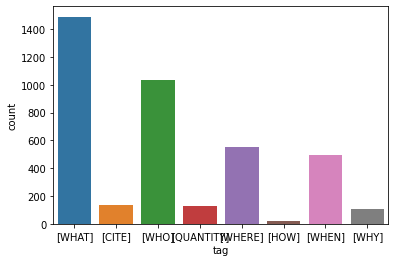

In [15]:
sns.countplot(x=df['tag'])
plt.show()

In [16]:
%%time
tags_how = Tags(how_sudo)
df_how = tags_how.apply()

CPU times: user 22.2 s, sys: 24 ms, total: 22.2 s
Wall time: 22.2 s


In [23]:
df_how['tag'].value_counts()

[WHAT]        469
[HOW]          80
[WHY]          58
[WHO]          26
[WHERE]        20
[QUANTITY]      2
[WHEN]          2
Name: tag, dtype: int64

In [17]:
%%time
tags_why = Tags(why_sudo)
df_why = tags_why.apply()

CPU times: user 8.27 s, sys: 16 ms, total: 8.28 s
Wall time: 8.29 s


In [18]:
df_why['tag'].value_counts()

[WHY]         110
[WHAT]        108
[WHERE]        25
[WHO]          16
[HOW]          13
[QUANTITY]      3
[WHEN]          1
Name: tag, dtype: int64

In [19]:
%%time
tags_where = Tags(where_sudo)
df_where = tags_where.apply()

CPU times: user 2min 44s, sys: 208 ms, total: 2min 44s
Wall time: 2min 44s


In [20]:
df_where['tag'].value_counts()

[WHERE]       4685
[WHAT]        1182
[WHO]          140
[WHY]           23
[WHEN]          15
[HOW]           10
[QUANTITY]       8
Name: tag, dtype: int64

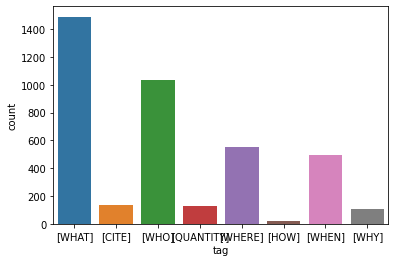

In [21]:
# augementation: 생성데이터(how, why, where) 추가 전
sns.countplot(x=df['tag'])
plt.show()

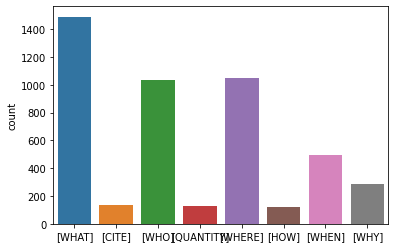

In [22]:
# augementation: 생성데이터(how, why, where) 추가 후
sns.countplot(x=pd.concat((df['tag'], pd.Series(['[HOW]']*100 + ['[WHY]']*180 + ['[WHERE]']*500))))
plt.show()

In [24]:
sudo_del = ['연방대법원이 연방법률을 가차없이 위헌 판결을 내려 입법하는 행위를 뭐라고 해?', '책 어떻게 우리들의 관념을 명석하게 만드는가라는 주제의 책은?', '왕지네는 어떻게 난생인가?', '군세가 적에게 미치지 못한데다가 식수마저 끊기어 어떻게 해갈하였는가?', "'누설전류(2)' 상태에서도 정보처리가 가능한 초절전 3진법 반도체 기술은 기존의 어떤 방식보다 계산 속도가 1,000배 이상 빠르고 소비전력도 적어 반도체 칩을 보다 작게 만들 수 있다는 장점이 존재하였는가?", '인디언 법의 입법화가 추진된 광대한 토지와 자원에 대한 요구 때문에 지정된 것은?', '가토 다쓰야는 왜 나는 한국에 승리하였나. 박근혜 정권과의 500일 전쟁이라는 책에서 대한민국은 대통령과 국민 감정에 따라 법이 어떻게 된다고 했어?']

In [25]:
df_sudo = pd.concat((df, 
                     df_how[(df_how['tag']=="HOW") | (df_how['tag']=="WHY")],
                     df_why[(df_why['tag']=="HOW") | (df_why['tag']=="WHY")],
                     df_where[(df_where['tag']=="HOW") | (df_where['tag']=="WHY")],
                     df_where[df_where['tag']=="WHERE"].reset_index(drop=True)[:500]))

In [27]:
df_new.to_csv("/opt/ml/code2/data/train_new_tag.tsv", header=None, index=False, sep='\t')

In [28]:
%%time
tags_valid = Tags(valid_dataset)
df_valid = tags_valid.apply()

CPU times: user 6.91 s, sys: 16 ms, total: 6.92 s
Wall time: 6.93 s


In [29]:
df_valid['tag'].value_counts()

[WHAT]        103
[WHO]          52
[WHERE]        36
[WHEN]         25
[CITE]         10
[WHY]           8
[QUANTITY]      6
Name: tag, dtype: int64

In [64]:
list(test_dataset['question'] + pd.read_csv('/opt/ml/code2/prediction/test_tag.csv')['tag'])

["유령'은 어느 행성에서 지구로 왔는가?[WHAT]",
 '용병회사의 경기가 좋아진 것은 무엇이 끝난 이후부터인가?[WHAT]',
 '돌푸스에게 불특정 기간동안 하원이 잠시 쉬는 것을 건의 받았던 인물은?[WHO]',
 '마오리언어와 영어, 뉴질랜드 수화를 공식 언어로 사용하는 나라는?[WHERE]',
 '디엔비엔푸 전투에서 보응우옌잡이 상대한 국가는?[WHERE]',
 '단공류가 일반 포유류와 다르다는 것을 알 수 있는 신체 부위는?[WHAT]',
 '상류 부르주아의 정치 독점을 불러일으킨 체계는?[WHAT]',
 '아시노 호가 만들어진 원인은 무엇인가?[WHY]',
 '흉년이 발생하고 곳곳에 난이 일어났던 시기는?[WHEN]',
 '급전궤도는 보통 무엇으로 만들어져 있는가?[WHAT]',
 '클레어에게 오세아닉 815편을 타라고 말한 사람의 이름은?[WHO]',
 '제6군이 18일 동안이나 대기해야 했던 장소는?[WHERE]',
 '누가 시장으로 선출되면서 트랜짓 시티 계획안이 불발되었나?[WHO]',
 '1차 대각성 운동이 일어나는데 큰 영향을 끼친 설교는 어디서 진행되었는가?[WHERE]',
 '괴수로부터 메구밍을 구해준 사람은 누구인가?[WHO]',
 '슈파이어 대성당 2차 축조시에 가장 우선순위로 고려했던 천장 건축 방식은?[WHAT]',
 '통대를 뽑을 수 있었던 주체는 누구인가?[WHO]',
 '이유립씨가 1970년대 중반에 본인의 글을 기고하기 시작한 곳은?[WHERE]',
 '미군이 충원되지 않으면 서울이 전쟁 시작 후 2주만에 함락될 것이라 밝힌 문서는?[WHAT]',
 '임경업 장군이 도를 닦은 곳으로 알려진 곳은?[WHERE]',
 '화재에서 인종을 구한 공으로 귀인으로 직위가 오른 사람은?[WHO]',
 '초등학생 일기검사의 인권침해 여부를 판단하는 주체는?[WHAT]',
 '콘스탄티누스가 군사 4만 명을 이끌고 침범한 나라는?[WHERE]',
 '불보살이 천도할 대상은?[WHO]',
 '루돌로지스트들이 게임에서 가장 주된 것이라 주

In [44]:
name = 'tdk12'
list(load_from_disk(f'/opt/ml/code2/data/sudo/{name}')['question'] + pd.read_csv(f'/opt/ml/code2/prediction/{name}_tag.csv')['tag'])

['대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?[WHAT]',
 '현대적 인사조직관리의 시발점이 된 책은?[CITE]',
 '강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?[WHO]',
 '11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?[WHAT]',
 '명문이 적힌 유물을 구성하는 그릇의 총 개수는?[QUANTITY]',
 '카드모스의 부하들이 간 곳에는 무엇이 있었는가?[WHAT]',
 '관우를 불태워 죽이려한 사람 누구인가?[WHO]',
 '참호 속에 무기와 장비를 버리고 도주한 집단은?[WHAT]',
 '제2차 세계 대전에 참전하여 사망한 자식은?[WHO]',
 '고려 공민왕이 처가 식구들과 아내와 함께 피신처로 삼은 마을은?[WHERE]',
 '정여창은 어떻게 죽었나?[HOW]',
 '아멜리아는 빅토르의 직업을 무엇으로 착각하나요?[WHAT]',
 '우핑가스 왕조의 이름은 어디서 유래하였나?[WHERE]',
 '장면이 한국으로 돌아온 년도는?[WHEN]',
 '유대교의 지나친 차별을 타파하려한 사람은?[WHO]',
 '권번에서 요릿집에 제공한 기생 명부의 이름은?[CITE]',
 '영국군 약 42만명의 사상자가 발생한 전투가 시작된 연도는?[WHEN]',
 '웨이크필드가 15번째 시즌에 활약한 팀의 이름은?[WHAT]',
 '김상옥이 종로경찰서에 폭탄을 던진 직후 피신한 곳은?[WHERE]',
 '윤치호가 극찬했던 조선시대의 인물은 누구인가요?[WHO]',
 '항우가 진나라를 멸하면서 조왕 헐은 어디로 이동했는가?[WHERE]',
 '30일에 한달 연장 근무를 신청하는 병사가 상금으로 받게 되는 금액은?[QUANTITY]',
 '슈만이 미군에게 포로로 잡혔던 년도는?[WHEN]',
 '김건의 할아버지가 세운 학교는?[WHERE]',
 '뇌에 탈피 신호를 보내는 부위는?[WHAT]',
 '툴민은 ≪코스모폴리스≫에서 근대과학과 무엇에 대해 비평하나요?[WHAT]',
 '아테네와 파트라간의 거리는?[QUANTIT